<a href="https://colab.research.google.com/github/19127592/Online-Retail-Data-Mining/blob/main/Data_Mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 36 kB/s 
     |████████████████████████████████| 199 kB 50.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=4b2007972e72adad042443b0ca90c7b096c01a86c76e618c793347253ba79a65
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


In [2]:
from pyspark.sql import *
from pyspark.ml.fpm import PrefixSpan
from pyspark.sql import Row
from pyspark import SparkContext
from math import ceil 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import seaborn as sns

In [3]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [4]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
downloaded = drive.CreateFile({'id':'1tMmTT4Her_Dw2aLbIcQdBmAJe5UIMU3Z'}) # replace the id with id of file you want to access
downloaded.GetContentFile('OnlineRetail.csv')

In [6]:
sc = SparkContext("local", "first app")
spark = SparkSession(sc)

## Đọc dữ liệu từ file

In [7]:
onlineretail_df = pd.read_csv('OnlineRetail.csv',encoding = 'unicode_escape')
onlineretail_df = onlineretail_df[onlineretail_df['CustomerID']==17841]
onlineretail_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1441,C536543,22632,HAND WARMER RED RETROSPOT,-1,12/1/2010 14:30,2.10,17841.0,United Kingdom
1442,C536543,22355,CHARLOTTE BAG SUKI DESIGN,-2,12/1/2010 14:30,0.85,17841.0,United Kingdom
2037,536557,21495,SKULLS AND CROSSBONES WRAP,25,12/1/2010 14:41,0.42,17841.0,United Kingdom
2038,536557,46000R,POLYESTER FILLER PAD 45x30cm,2,12/1/2010 14:41,1.45,17841.0,United Kingdom
2039,536557,46000S,POLYESTER FILLER PAD 40x40cm,1,12/1/2010 14:41,1.45,17841.0,United Kingdom
...,...,...,...,...,...,...,...,...
537749,581334,23399,HOME SWEET HOME HANGING HEART,3,12/8/2011 12:07,0.85,17841.0,United Kingdom
537750,581334,22893,MINI CAKE STAND T-LIGHT HOLDER,12,12/8/2011 12:07,0.42,17841.0,United Kingdom
537751,581334,22371,AIRLINE BAG VINTAGE TOKYO 78,1,12/8/2011 12:07,4.25,17841.0,United Kingdom
537752,581334,22309,TEA COSY RED STRIPE,1,12/8/2011 12:07,2.55,17841.0,United Kingdom


### Chuyển cột InvoiceDate sang kiểu datetime

In [8]:
onlineretail_df['InvoiceDate'] = pd.to_datetime(onlineretail_df['InvoiceDate'],format='%m/%d/%Y %H:%M')

Thuật toán Lossy Counting


In [9]:
class LossyCount:  
    def __init__(self, max_error=0.005):  
        self.max_error = max_error  
        self.bucket_width = ceil(1/max_error)  
        self.entries = dict()  
        self.n = 0  
  
    def put(self, x):  
        self.n += 1  
        current_bucket = ceil(self.n / self.bucket_width)  
  
        freq, delta = 1, current_bucket-1  
        if x in self.entries:  
            freq, delta = self.entries[x]  
            freq += 1  
        self.entries[x] = (freq, delta)  
  
       
        if self.n % self.bucket_width == 0:  
            prune = []  
            for key in self.entries:  
                freq, delta = self.entries[key]  
                if freq + delta <= current_bucket:  
                    prune.append(key)  
            for key in prune:  
                del self.entries[key]  
  
    def get(self, support_threshold):  
        res = []  
        for key in self.entries:  
            freq, delta = self.entries[key]  
            if freq >= (support_threshold - self.max_error)*self.n:  
                res.append(key)  
        return res

Lấy những mặt hàng từ năm 2010

In [10]:
mining_stream_df = onlineretail_df[onlineretail_df['InvoiceDate'].dt.year==2010]

Chạy thuật toán Lossy Counting


In [11]:
threshold = 0.02
Description = mining_stream_df['Description'].values
lc = LossyCount()  
for v in Description:  
    lc.put(v)  
print(np.sort(lc.get(threshold)))  

['CHILLI LIGHTS' 'DISCO BALL CHRISTMAS DECORATION' 'SANDWICH BATH SPONGE'
 'WHITE SKULL HOT WATER BOTTLE ']


Because time-series is continous data over time, we take all the records without filtering.

In [12]:
onlineretail_df_withoutfilter = pd.read_csv('OnlineRetail.csv',encoding = 'unicode_escape')
time_series_df = onlineretail_df_withoutfilter[['InvoiceDate','Quantity','UnitPrice']]

In [13]:
time_series_df['InvoiceDate'] = pd.to_datetime(time_series_df['InvoiceDate'],format='%m/%d/%Y %H:%M')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Tính doanh thu bằng cách lấy cột `Quantity` nhân với `UnitPrice` sau đó lưu vào cột `Total`

In [14]:
time_series_df['Total']=time_series_df['Quantity']*time_series_df['UnitPrice']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [15]:
time_series_df

,InvoiceDate,Quantity,UnitPrice,Total
0,2010-12-01 08:26:00,6,2.55,15.30
1,2010-12-01 08:26:00,6,3.39,20.34
2,2010-12-01 08:26:00,8,2.75,22.00
3,2010-12-01 08:26:00,6,3.39,20.34
4,2010-12-01 08:26:00,6,3.39,20.34
...,...,...,...,...
541904,2011-12-09 12:50:00,12,0.85,10.20
541905,2011-12-09 12:50:00,6,2.10,12.60
541906,2011-12-09 12:50:00,4,4.15,16.60
541907,2011-12-09 12:50:00,4,4.15,16.60


### Tính tổng doanh thu theo thời gian

In [16]:
time_series_df=time_series_df.groupby(['InvoiceDate']).agg({'Total':'sum'})

### Doanh thu năm 2010

In [17]:
time_series_df=time_series_df.loc[time_series_df.index.year==2010]

### Làm trơn dữ liệu liệu bằng phương pháp SMA

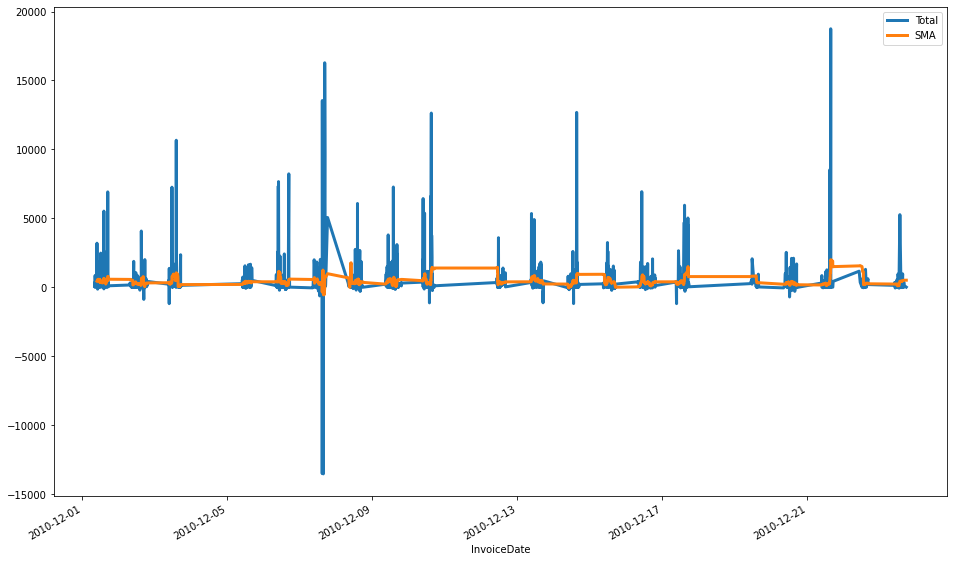

In [18]:
time_series_df['SMA'] = time_series_df['Total'].rolling(20).mean()
time_series_df[['Total','SMA']].plot(label='RELIANCE',figsize=(16, 10),linewidth=3)

### Làm trơn dữ liệu liệu bằng phương pháp EMA

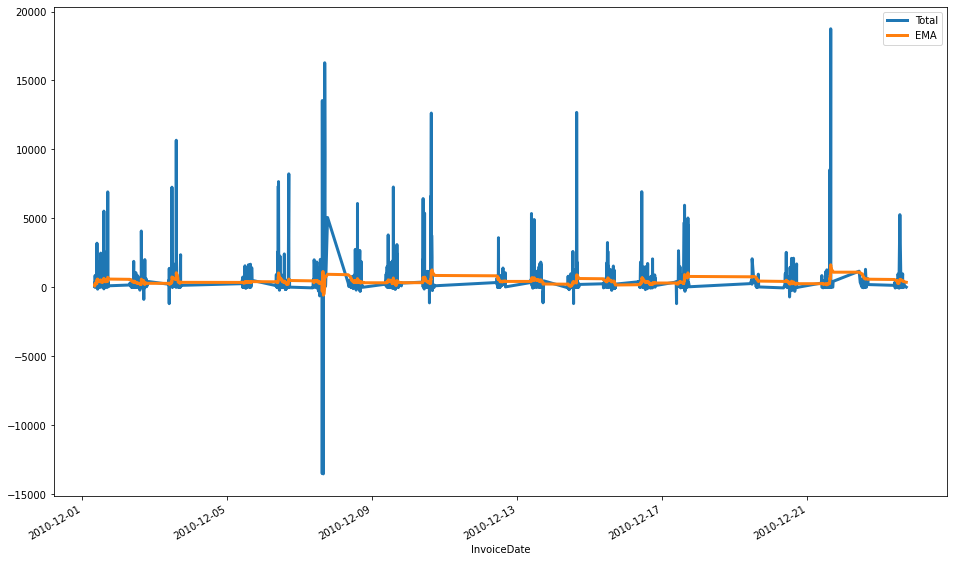

In [19]:
time_series_df['EMA'] = time_series_df['Total'].ewm(20).mean()
time_series_df[['Total','EMA']].plot(label='RELIANCE',figsize=(16, 10),linewidth=3)

### PrefixSpan Data Mining

In [20]:
new_onlineretail_df = onlineretail_df[['InvoiceNo','InvoiceDate','Description']]
new_onlineretail_df['InvoiceDate'] = pd.to_datetime(new_onlineretail_df['InvoiceDate'],format='%m/%d/%Y %H:%M').dt.date
new_onlineretail_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,InvoiceNo,InvoiceDate,Description
1441,C536543,2010-12-01,HAND WARMER RED RETROSPOT
1442,C536543,2010-12-01,CHARLOTTE BAG SUKI DESIGN
2037,536557,2010-12-01,SKULLS AND CROSSBONES WRAP
2038,536557,2010-12-01,POLYESTER FILLER PAD 45x30cm
2039,536557,2010-12-01,POLYESTER FILLER PAD 40x40cm
...,...,...,...
537749,581334,2011-12-08,HOME SWEET HOME HANGING HEART
537750,581334,2011-12-08,MINI CAKE STAND T-LIGHT HOLDER
537751,581334,2011-12-08,AIRLINE BAG VINTAGE TOKYO 78
537752,581334,2011-12-08,TEA COSY RED STRIPE


In [21]:
new_onlineretail = new_onlineretail_df.groupby(by=['InvoiceNo','InvoiceDate'])['Description'].apply(np.array).reset_index()
new_onlineretail = new_onlineretail[['InvoiceDate','Description']]
new_onlineretail

,InvoiceDate,Description
0,2010-12-01,"[SKULLS AND CROSSBONES WRAP, POLYESTER FILLER ..."
1,2010-12-03,"[12 RED ROSE PEG PLACE SETTINGS, APPLE BATH SP..."
2,2010-12-06,"[CHILLI LIGHTS, METAL 4 HOOK HANGER FRENCH CHA..."
3,2010-12-09,"[JUMBO BAG OWLS, JUMBO STORAGE BAG SUKI, VICTO..."
4,2010-12-14,"[ART LIGHTS,FUNK MONKEY, CABIN BAG VINTAGE RET..."
...,...,...
164,2011-11-04,"[ASSTD FRUIT+FLOWERS FRIDGE MAGNETS, SET OF 3 ..."
165,2011-11-04,[WHITE TRAVEL ALARM CLOCK]
166,2011-11-20,"[RED METAL BOX TOP SECRET, BLUE/CREAM STRIPE C..."
167,2011-11-23,"[BLUE/CREAM STRIPE CUSHION COVER , CHRISTMAS T..."


In [22]:
description_arr = []
unqiue_date = list(new_onlineretail['InvoiceDate'].unique())
for date in unqiue_date:
    desc = new_onlineretail[new_onlineretail['InvoiceDate'] == date]['Description']
    l = []
    for d in desc:
        l.append(d)
    description_arr.append(l)

for idx1,i in enumerate(description_arr):
    for idx2,j in enumerate(i):
      description_arr[idx1][idx2] = description_arr[idx1][idx2].tolist()

In [23]:
df = sc.parallelize([Row(sequence=description_arr[0]),
                     Row(sequence=description_arr[1]),
                     Row(sequence=description_arr[2]),
                     Row(sequence=description_arr[3]),
                     Row(sequence=description_arr[4]),
                     Row(sequence=description_arr[5]),
                     Row(sequence=description_arr[6]),
                     Row(sequence=description_arr[7]),
                     Row(sequence=description_arr[8]),
                     Row(sequence=description_arr[9]),
                     Row(sequence=description_arr[10]),
                     Row(sequence=description_arr[11]),
                     Row(sequence=description_arr[12]),
                     Row(sequence=description_arr[13]),
                     Row(sequence=description_arr[14]),
                     Row(sequence=description_arr[15]),
                     Row(sequence=description_arr[16]),
                     Row(sequence=description_arr[17]),
                     Row(sequence=description_arr[18]),
                     Row(sequence=description_arr[19]),
                     Row(sequence=description_arr[20]),
                     Row(sequence=description_arr[21]),
                     Row(sequence=description_arr[22]),
                     Row(sequence=description_arr[23]),
                     Row(sequence=description_arr[24]),
                     Row(sequence=description_arr[25]),
                     Row(sequence=description_arr[26]),
                     Row(sequence=description_arr[27]),
                     Row(sequence=description_arr[28]),
                     Row(sequence=description_arr[29]),
                     Row(sequence=description_arr[30]),
                     Row(sequence=description_arr[31]),
                     Row(sequence=description_arr[32]),
                     Row(sequence=description_arr[33]),
                     Row(sequence=description_arr[34]),
                     Row(sequence=description_arr[35]),
                     Row(sequence=description_arr[36]),
                     Row(sequence=description_arr[37]),
                     Row(sequence=description_arr[38]),
                     Row(sequence=description_arr[39]),
                     Row(sequence=description_arr[40]),
                     Row(sequence=description_arr[41]),
                     Row(sequence=description_arr[42]),
                     Row(sequence=description_arr[43]),
                     Row(sequence=description_arr[44]),
                     Row(sequence=description_arr[45]),
                     Row(sequence=description_arr[46]),
                     Row(sequence=description_arr[47]),
                     Row(sequence=description_arr[48]),
                     Row(sequence=description_arr[49]),
                     Row(sequence=description_arr[50]),
                     Row(sequence=description_arr[51]),
                     Row(sequence=description_arr[52]),
                     Row(sequence=description_arr[53]),
                     Row(sequence=description_arr[54]),
                     Row(sequence=description_arr[55]),
                     Row(sequence=description_arr[56]),
                     Row(sequence=description_arr[57]),
                     Row(sequence=description_arr[58]),
                     Row(sequence=description_arr[59]),
                     Row(sequence=description_arr[60]),
                     Row(sequence=description_arr[61]),
                     Row(sequence=description_arr[62]),
                     Row(sequence=description_arr[63]),
                     Row(sequence=description_arr[64]),
                     Row(sequence=description_arr[65]),
                     Row(sequence=description_arr[66]),
                     Row(sequence=description_arr[67]),
                     Row(sequence=description_arr[68]),
                     Row(sequence=description_arr[69]),
                     Row(sequence=description_arr[70]),
                     Row(sequence=description_arr[71]),
                     Row(sequence=description_arr[72]),
                     Row(sequence=description_arr[73]),
                     Row(sequence=description_arr[74]),
                     Row(sequence=description_arr[75]),
                     Row(sequence=description_arr[76]),
                     Row(sequence=description_arr[78]),
                     Row(sequence=description_arr[79]),
                     Row(sequence=description_arr[80]),
                     Row(sequence=description_arr[81]),
                     Row(sequence=description_arr[82]),
                     Row(sequence=description_arr[83]),
                     Row(sequence=description_arr[84]),
                     Row(sequence=description_arr[85]),
                     Row(sequence=description_arr[86]),
                     Row(sequence=description_arr[87]),
                     Row(sequence=description_arr[88]),
                     Row(sequence=description_arr[89]),
                     Row(sequence=description_arr[90]),
                     Row(sequence=description_arr[91]),
                     Row(sequence=description_arr[92]),
                     Row(sequence=description_arr[93]),
                     Row(sequence=description_arr[94]),
                     Row(sequence=description_arr[95]),
                     Row(sequence=description_arr[96]),
                     Row(sequence=description_arr[97]),
                     Row(sequence=description_arr[98]),
                     Row(sequence=description_arr[99]),
                     Row(sequence=description_arr[100]),
                     Row(sequence=description_arr[101]),
                     Row(sequence=description_arr[102]),
                     Row(sequence=description_arr[103]),
                     Row(sequence=description_arr[104]),
                     Row(sequence=description_arr[105]),
                     Row(sequence=description_arr[106]),
                     Row(sequence=description_arr[107]),
                     Row(sequence=description_arr[108]),
                     Row(sequence=description_arr[109]),
                     Row(sequence=description_arr[110]),
                     Row(sequence=description_arr[111]),
                     Row(sequence=description_arr[112])
                    ]).toDF()

In [24]:
df.printSchema()

root
 |-- sequence: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: string (containsNull = true)



In [25]:
df.show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [26]:
prefixSpan = PrefixSpan(minSupport=0.3)
prefixSpan.findFrequentSequentialPatterns(df).sort("sequence").show(truncate=False)

+--------------------------------------+----+
|sequence                              |freq|
+--------------------------------------+----+
|[[BLUE/CREAM STRIPE CUSHION COVER ]]  |50  |
|[[CHARLOTTE BAG SUKI DESIGN]]         |46  |
|[[CHILLI LIGHTS]]                     |62  |
|[[DISCO BALL CHRISTMAS DECORATION]]   |36  |
|[[GUMBALL COAT RACK]]                 |44  |
|[[PACK OF 60 DINOSAUR CAKE CASES]]    |46  |
|[[RECORD FRAME 7" SINGLE SIZE ]]      |38  |
|[[SKULL DESIGN TV DINNER TRAY]]       |41  |
|[[SMALL PURPLE BABUSHKA NOTEBOOK ]]   |34  |
|[[SMALL YELLOW BABUSHKA NOTEBOOK ]]   |34  |
|[[SUKI  SHOULDER BAG]]                |40  |
|[[WHITE SPOT RED CERAMIC DRAWER KNOB]]|38  |
+--------------------------------------+----+

